In [1]:
import pickle
import torch
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import to_undirected
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from typing import List
from tqdm import tqdm
from rdkit.Chem.rdMolAlign import GetBestRMS
from ccdc.conformer import ConformerGenerator
from ccdc.molecule import Molecule
from ccdc.descriptors import MolecularDescriptors
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem.TorsionFingerprints import GetTFDBetweenConformers
from rdkit.Chem.TorsionFingerprints import CalculateTorsionLists
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
from collections import defaultdict
from torch_geometric.data import Batch

In [2]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
import py3Dmol

In [3]:
from litschnet import LitSchNet
from molecule_encoders import MoleculeEncoders
from molecule_featurizer import MoleculeFeaturizer
from mol_viewer import MolViewer
from ccdc_rdkit_connector import CcdcRdkitConnector

In [4]:
data_dir = 'data/'
pdbbind_refined_dir = '/home/benoit/PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir = '/home/benoit/PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [5]:
with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_0.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]
    
with open(os.path.join(data_dir, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    cel = pickle.load(f)

In [6]:
connector = CcdcRdkitConnector()

encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
if os.path.exists(encoder_path) : # Load existing encoder
    with open(encoder_path, 'rb') as f:
        mol_encoders = pickle.load(f)
mol_featurizer = MoleculeFeaturizer(mol_encoders)

experiment_name = f'random_split_0_new'
if experiment_name in os.listdir('lightning_logs') :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
litschnet.eval()

LitSchNet(
  (schnet): SchNet(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [7]:
mol_viewer = MolViewer()

In [8]:
def data_list_to_conf_ensemble(data_list, mol) :
    new_mol = copy.deepcopy(mol)
    n_gen = len(data_list) - mol.GetNumConformers()
    for data in data_list[-n_gen:] :
        dummy_mol = copy.deepcopy(mol)
        new_conf = dummy_mol.GetConformer()
        for ai, pos in enumerate(new_conf.GetPositions()) :
            point3d = Point3D(*data.pos[ai].numpy().tolist())
            new_conf.SetAtomPosition(ai, point3d)
        new_mol.AddConformer(new_conf, assignId=True)
    return new_mol

In [9]:
def explore_torsion_space(mol, litschnet) :
    data_list = mol_featurizer.featurize_mol(mol)
    batch = Batch.from_data_list(data_list)
    rmsd = mol_featurizer.get_bioactive_rmsds(mol)
    pred_rmsd = litschnet(batch)
    plt.scatter(rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()

    mol_viewer.view(mol)
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    generated_ids = [conf.GetId() for conf in mol.GetConformers() if conf.HasProp('Generator')]
    n_gen = len(generated_ids)
    
    for torsion_atoms in torsions :
        angles = range(-180, 180, 1)
        explore_data_list = []
        for angle in angles :
            dummy_mol = copy.deepcopy(mol) 
            conf = dummy_mol.GetConformer(0)
            SetDihedralDeg(conf, *torsion_atoms, angle)
            data = mol_featurizer.conf_to_data(rdkit_mol=dummy_mol, conf_id=0, edge_index=data_list[0].edge_index, z=data_list[0].z)
            explore_data_list.append(data)

        loader = DataLoader(explore_data_list, batch_size=24)
        pred_rmsd = []
        for batch in loader :
            pred = litschnet(batch)
            pred_rmsd.extend(pred.detach().numpy().tolist())

        plt.figure(figsize=(10,5))
        plt.plot(angles, pred_rmsd)
        plt.xlabel('Torsion angle')
        plt.ylabel('Predicted RMSD')
        plt.axvline(GetDihedralDeg(mol.GetConformer(0), *torsion_atoms), label='Bioactive', c='green', linewidth=5)
        for generated_id in generated_ids :
            conf = mol.GetConformer(generated_id)
            plt.axvline(GetDihedralDeg(conf, *torsion_atoms), c='red', label='Generated')
            
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

In [10]:
def explore_torsion_space_2d(mol, litschnet) :
    data_list = mol_featurizer.featurize_mol(mol)
    batch = Batch.from_data_list(data_list)
    rmsd = mol_featurizer.get_bioactive_rmsds(mol)
    pred_rmsd = litschnet(batch)
    plt.scatter(rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()

    mol_viewer.view(mol)
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    generated_ids = [conf.GetId() for conf in mol.GetConformers() if conf.HasProp('Generator')]
    n_gen = len(generated_ids)
    
    n_gen = new_mol.GetNumConformers() - mol.GetNumConformers()
    for i, torsion_atoms1 in enumerate(torsions) :
        for torsion_atoms2 in torsions[i+1:] :
            angles = list(range(-180, 180, 5))
            explore_data_list = []
            for angle1 in angles :
                for angle2 in angles :
                    dummy_mol = copy.deepcopy(mol) 
                    conf = dummy_mol.GetConformer(0)
                    SetDihedralDeg(conf, *torsion_atoms1, angle1)
                    SetDihedralDeg(conf, *torsion_atoms2, angle2)
                    data = mol_featurizer.conf_to_data(rdkit_mol=dummy_mol, conf_id=0, edge_index=data_list[0].edge_index, z=data_list[0].z)
                    explore_data_list.append(data)
                
            loader = DataLoader(explore_data_list, batch_size=24)
            pred_rmsd = []
            for batch in loader :
                pred = litschnet(batch)
                pred_rmsd.extend(pred.detach().numpy().tolist())
                
            pred_rmsd = np.array(pred_rmsd).reshape(len(angles), len(angles))

            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
            cax = ax.matshow(pred_rmsd, extent=[-180, 180, -180, 180])
            fig.colorbar(cax)
            plt.xlabel('Angle1')
            plt.ylabel('Angle2')
            real_torsion1 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms1)
            real_torsion2 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms2)
            ax.set_title(f'{torsion_atoms1} : {int(real_torsion1)} X {torsion_atoms2} : {int(real_torsion2)}')
            plt.show()

In [11]:
all_smiles = [smiles for smiles, ce in cel.get_unique_molecules()]

In [12]:
mol = cel.get_conf_ensemble(all_smiles[0]).mol

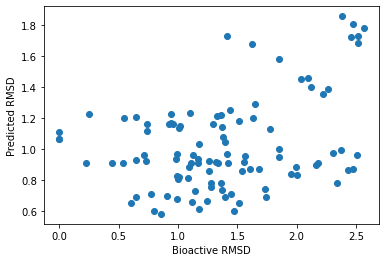

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(IntSlider(value=0, description='conf_id', max=102), Output()), _dom_classes=('widget-int…

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


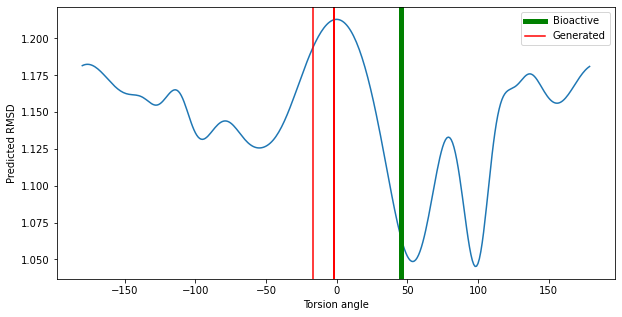

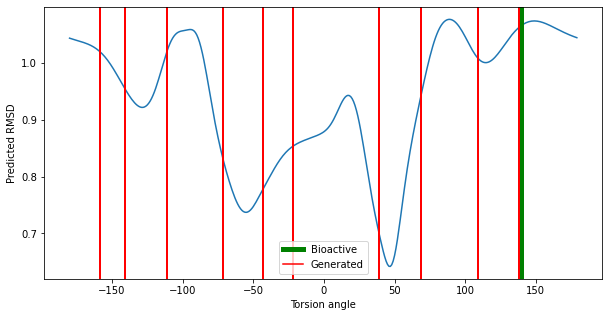

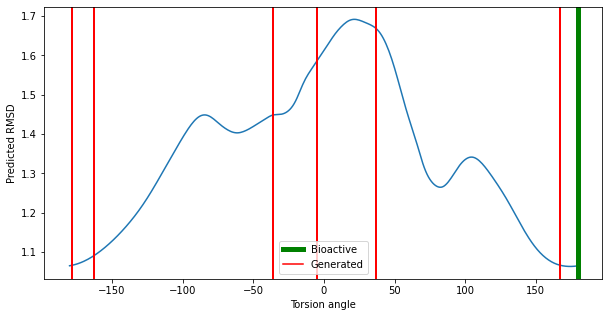

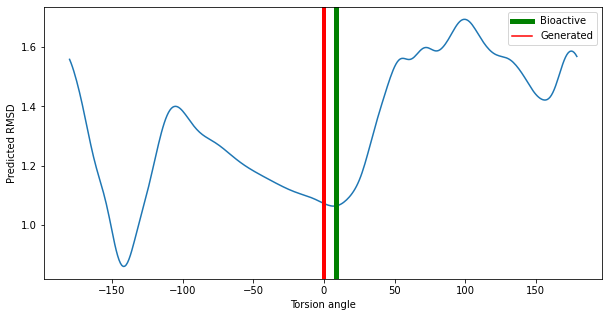

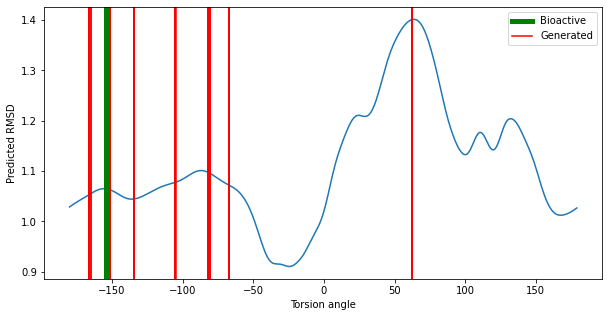

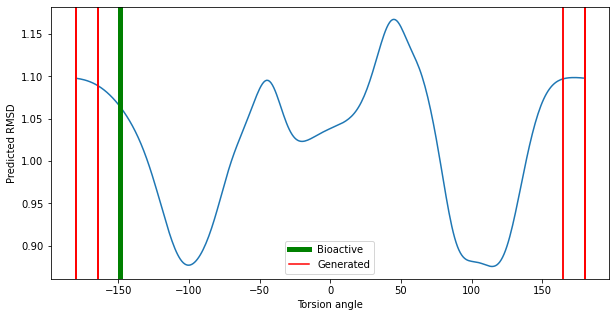

In [13]:
explore_torsion_space(mol, litschnet)

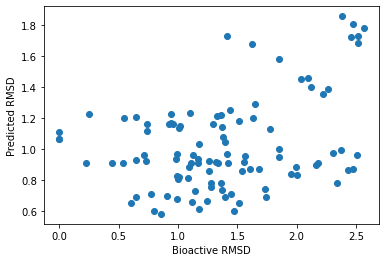

interactive(children=(IntSlider(value=0, description='conf_id', max=102), Output()), _dom_classes=('widget-int…

NameError: name 'new_mol' is not defined

In [14]:
explore_torsion_space_2d(mol, litschnet)

In [15]:
def scoring_function(inputs, data_list, mol, torsions) :
    dummy_mol = copy.deepcopy(mol)
    conf = dummy_mol.GetConformer(0)
    for i, input in enumerate(inputs) :
        SetDihedralDeg(conf, *torsions[i], input)
    data = mol_featurizer.conf_to_data(rdkit_mol=dummy_mol, conf_id=0, edge_index=data_list[0].edge_index, z=data_list[0].z)
    data_list = [data]
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch).detach().numpy()
    output = pred_rmsd[0][0]
    return output

In [16]:
from scipy.optimize import minimize

In [17]:
def ccdc_rmsd_rdkit_mol(rdkit_mol, conf_id1, conf_id2) :
    molblock1 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id1)
    molblock2 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id2)
    ccdc_mol1 = Molecule.from_string(molblock1)
    ccdc_mol2 = Molecule.from_string(molblock2)
    return MolecularDescriptors.overlay_rmsds_and_transformation(ccdc_mol1, ccdc_mol2)[1]

In [18]:
def optimize_torsions(mol, view_mol=False) :
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    data_list = mol_featurizer.featurize_mol(mol)
    xbioactive = [GetDihedralDeg(mol.GetConformer(0), *torsion_atoms) for torsion_atoms in torsions]
    try :
        generated_ids = [conf.GetId() for conf in mol.GetConformers() if conf.HasProp('Generator')]
        n_gen = len(generated_ids)
        gen_conf_id = generated_ids[0]

        x0 = [GetDihedralDeg(mol.GetConformer(gen_conf_id), *torsion_atoms) for torsion_atoms in torsions]
        #print(x0)

        opt = minimize(scoring_function, x0, args=(data_list, mol, torsions), method='Nelder-Mead')
        #print(f'Optimal predicted RMSD : {opt.fun}')
        solution = opt.x
        
#         print([int(x) for x in xbioactive])
#         print([int(x) for x in x0])
#         print([int(x) for x in solution])

        new_mol = copy.deepcopy(mol)
        new_mol.RemoveAllConformers()
        new_mol.AddConformer(mol.GetConformer(0), assignId=True)

        dummy_mol = copy.deepcopy(new_mol)
        optimized_conf = dummy_mol.GetConformer(0)
        for i, angle in enumerate(solution) :
            SetDihedralDeg(optimized_conf, *torsions[i], angle)
        optimized_conf_id = new_mol.AddConformer(optimized_conf, assignId=True)
        
        rmsd_optimized_to_bioactive = ccdc_rmsd_rdkit_mol(new_mol, 0, optimized_conf_id)
        #print(f'RMSD optimized to bioactive : {rmsd_optimized_to_bioactive}')

        gen_conf_id = new_mol.AddConformer(mol.GetConformer(gen_conf_id), assignId=True)
        rmsd_generated_to_bioactive = ccdc_rmsd_rdkit_mol(new_mol, 0, gen_conf_id)
        #print(f'RMSD generated to bioactive : {rmsd_generated_to_bioactive}')
        
        rmsd_optimized_to_generated = ccdc_rmsd_rdkit_mol(new_mol, optimized_conf_id, gen_conf_id)
        #print(f'RMSD generated to bioactive : {rmsd_generated_to_bioactive}')
        
        if view_mol :
            mol_viewer.view(new_mol)

        return rmsd_optimized_to_bioactive, rmsd_generated_to_bioactive, rmsd_optimized_to_generated, opt.fun
        
    except Exception as e:
        print('Error in generation')
        print(str(e))

In [ ]:
robs = []
rgbs = []
rogs = []
preds = []
gains = []
for smiles in tqdm(test_smiles) :
    mol = cel.get_conf_ensemble(smiles).mol
    try :
        rob, rgb, rog, pred = optimize_torsions(mol)
        gain = rob - rgb
        robs.append(rob)
        rgbs.append(rgb)
        rogs.append(rog)
        preds.append(pred)
        gains.append(gain)
    except Exception as e:
        print(f'Error for smiles {smiles}')
        print(str(e))

  1%|▌                                      | 15/1110 [06:20<7:01:10, 23.08s/it]

In [ ]:
import seaborn as sns

In [ ]:
all_values = []
all_targets = []

all_values.extend(robs)
all_targets.extend(['ROBS' for _ in robs])

all_values.extend(rgbs)
all_targets.extend(['RGBS' for _ in rgbs])

all_values.extend(rogs)
all_targets.extend(['ROGS' for _ in rogs])

all_values.extend(preds)
all_targets.extend(['Preds' for _ in preds])

In [ ]:
import pandas as pd
df = pd.DataFrame()

In [ ]:
df['values'] = pd.Series(all_values)
df['targets'] = pd.Series(all_targets)

In [ ]:
sns.boxplot(data=df, x='targets', y='values')

In [ ]:
sns.kdeplot(data=df, x='values', hue='targets')

In [ ]:
sns.boxplot(y=gains)